In [1]:
import tensorflow as tf
print("Tensorflow Version: ", tf.__version__)

Tensorflow Version:  2.4.0


In [2]:
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
import numpy as np
import pandas as pd

In [4]:
from saved_class_MultiHeadAttention import MultiHeadAttention
from saved_class_PositionalEncoding import PositionalEncoding

from saved_func_bleu import bleu
from saved_func_try_gpu import try_gpu
from saved_func_load_data_nmt import *
from saved_func_train_seq2seq import train_seq2seq
from saved_func_show_heatmaps import show_heatmaps

## Position-wise feed forward networks

In [5]:
class PositionWiseFFN(tf.keras.layers.Layer):
    def __init__(self, ffn_num_hiddens, ffn_num_outputs, **kwargs):
        super().__init__(*kwargs)
        self.dense1 = tf.keras.layers.Dense(ffn_num_hiddens)
        self.relu = tf.keras.layers.ReLU()
        self.dense2 = tf.keras.layers.Dense(ffn_num_outputs)

    def call(self, X):
        return self.dense2(self.relu(self.dense1(X)))

In [6]:
ffn = PositionWiseFFN(4, 8)
ffn(tf.ones((2, 3, 4)))[0]

<tf.Tensor: shape=(3, 8), dtype=float32, numpy=
array([[-0.15783018,  0.16745974, -0.37032843,  0.04140934, -0.18345703,
        -0.15033993, -0.18183942,  0.05790496],
       [-0.15783018,  0.16745974, -0.37032843,  0.04140934, -0.18345703,
        -0.15033993, -0.18183942,  0.05790496],
       [-0.15783018,  0.16745974, -0.37032843,  0.04140934, -0.18345703,
        -0.15033993, -0.18183942,  0.05790496]], dtype=float32)>

## Residual connection and layer normalization

In [7]:
ln = tf.keras.layers.LayerNormalization()
bn = tf.keras.layers.BatchNormalization()
X = tf.constant([[1, 2], [2, 3]], dtype = tf.float32)
print('layer norm:', ln(X), '\nbatch norm:', bn(X, training = True))

layer norm: tf.Tensor(
[[-0.998006   0.9980061]
 [-0.9980061  0.998006 ]], shape=(2, 2), dtype=float32) 
batch norm: tf.Tensor(
[[-0.998006   -0.9980061 ]
 [ 0.9980061   0.99800587]], shape=(2, 2), dtype=float32)


In [8]:
class AddNorm(tf.keras.layers.Layer):
    def __init__(self, normalized_shape, dropout, **kwargs):
        super().__init__(**kwargs)
        self.dropout = tf.keras.layers.Dropout(dropout)
        self.ln = tf.keras.layers.LayerNormalization(normalized_shape)
        
    def call(self, X, Y, training):
        return self.ln(self.dropout(Y, training = training) + X)

In [9]:
add_norm = AddNorm([1, 2], 0.5) # Normalized_shape is: [i for i in range(len(input.shape))][1:]
add_norm(tf.ones((2, 3, 4)), tf.ones((2, 3, 4)), training = False).shape

TensorShape([2, 3, 4])

## Encoder

In [10]:
class EncoderBlock(tf.keras.layers.Layer):
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_hiddens, num_heads, dropout, bias = False, **kwargs):
        super().__init__(**kwargs)
        self.attention = MultiHeadAttention(key_size, query_size, value_size, num_hiddens,
                                            num_heads, dropout, bias)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(norm_shape, dropout)
        
    def call(self, X, valid_lens, training):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens, training = training), training = training)
        return self.addnorm2(Y, self.ffn(Y), training = training)

In [11]:
X = tf.ones((2, 100, 24))
valid_lens = tf.constant([3, 2])
norm_shape = [i for i in range(len(X.shape))][1:]
encoder_blk = EncoderBlock(24, 24, 24, 24, norm_shape, 48, 8, 0.5)
encoder_blk(X, valid_lens, training = False).shape

TensorShape([2, 100, 24])

In [12]:
class TransformerEncoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, key_size, query_size, value_size, num_hiddens, norm_shape,
                 ffn_num_hiddens, num_heads, num_layers, dropout, bias = False, **kwargs):
        super().__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.embedding = tf.keras.layers.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = PositionalEncoding(num_hiddens, dropout)
        self.blks = [EncoderBlock(key_size, query_size, value_size, num_hiddens, norm_shape,
                                  ffn_num_hiddens, num_heads, dropout, bias) for _ in range(num_layers)]
        
    def call(self, X, valid_lens, training, *args):
        # Since positional encoding values are between -1 and 1, the embedding
        # values are multiplied by the square root of the embedding dimension
        # to rescale before they are summed up
        X = self.pos_encoding(self.embedding(X) * tf.math.sqrt(tf.cast(self.num_hiddens, dtype = tf.float32)),
                              training = training)
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens, training = training)
            self.attention_weights[i] = blk.attention.attention.attention_weights
        return X

In [13]:
encoder = TransformerEncoder(200, 24, 24, 24, 24, [1, 2], 48, 8, 2, 0.5)
encoder(tf.ones((2, 100)), valid_lens, training = False).shape

TensorShape([2, 100, 24])

In [14]:
class DecoderBlock(tf.keras.layers.Layer):
    # The `i`-th block in the decoder
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_hiddens, num_heads, dropout, i, **kwargs):
        super().__init__(**kwargs)
        self.i = i
        self.attention1 = MultiHeadAttention(key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.attention2 = MultiHeadAttention(key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm2 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_hiddens, num_hiddens)
        self.addnorm3 = AddNorm(norm_shape, dropout)
        
    def call(self, X, state, training):
        enc_outputs, enc_valid_lens = state[0], state[1]
        # During training, all the tokens of any output sequence are processed
        # at the same time, so `state[2][self.i]` is `None` as initialized.
        # When decoding any output sequence token by token during prediction,
        # `state[2][self.i]` contains representations of the decoded output at
        # the `i`-th block up to the current time step
        if state[2][self.i] is None:
            key_values = X
        else:
            key_values = tf.concat((state[2][self.i], X), axis = 1)
        state[2][self.i] = key_values
        if training:
            batch_size, num_steps, _ = X.shape
            # Shape of `dec_valid_lens`: (`batch_size`, `num_steps`), where
            # every row is [1, 2, ..., `num_steps`]
            dec_valid_lens = tf.repeat(tf.reshape(tf.range(1, num_steps + 1),
                                                 shape = (-1, num_steps)), repeats = batch_size, axis = 0)

        else:
            dec_valid_lens = None
            
        # Self-attention
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens, training = training)
        Y = self.addnorm1(X, X2, training = training)
        # Encoder-decoder attention. Shape of `enc_outputs`: (`batch_size`, `num_steps`, `num_hiddens`)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens, training = training)
        Z = self.addnorm2(Y, Y2, training = training)
        return self.addnorm3(Z, self.ffn(Z), training = training), state

In [15]:
decoder_blk = DecoderBlock(24, 24, 24, 24, [1, 2], 48, 8, 0.5, 0)
X = tf.ones((2, 100, 24))
state = [encoder_blk(X, valid_lens), valid_lens, [None]]
decoder_blk(X, state, training = False)[0].shape

TensorShape([2, 100, 24])

In [16]:
class TransformerDecoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_hidens, num_heads, num_layers, dropout, **kwargs):
        super().__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.embedding = tf.keras.layers.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = PositionalEncoding(num_hiddens, dropout)
        self.blks = [DecoderBlock(key_size, query_size, value_size, num_hiddens, norm_shape,
                                  ffn_num_hiddens, num_heads, dropout, i) for i in range(num_layers)]
        self.dense = tf.keras.layers.Dense(vocab_size)
        
    def init_state(self, enc_outputs, enc_valid_lens, *args):
        return [enc_outputs, enc_valid_lens, [None] * self.num_layers]
    
    def call(self, X, state, training):
        X = self.pos_encoding(self.embedding(X) * tf.math.sqrt(tf.cast(self.num_hiddens, dtype = tf.float32)),
                              training = training)
        self.attention_weights = [[None] * len(self.blks) for _ in range(2)]  # 2 Attention layers in decoder
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state, training = training)
            # Decoder self-attention weights
            self.attention_weights[0][i] = blk.attention1.attention.attention_weights
            # Encoder-decoder attention weights
            self.attention_weights[1][i] = blk.attention2.attention.attention_weights
        return self.dense(X), state
    
    def attention_weights(self):
        return self.attention_weights

## Transformer model

In [17]:
class Transformer(tf.keras.Model):
    def __init__(self, src_vocab_len, tgt_vocab_len, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_hiddens, num_heads, num_layers, dropout, **kwargs):
        super().__init__(**kwargs)
        self.encoder = TransformerEncoder(src_vocab_len, key_size, query_size, value_size, num_hiddens, norm_shape,
                                          ffn_num_hiddens, num_heads, num_layers, dropout)
        self.decoder = TransformerDecoder(tgt_vocab_len, key_size, query_size, value_size, num_hiddens, norm_shape,
                                          ffn_num_hiddens, num_heads, num_layers, dropout)
    
    def call(self, enc_X, dec_X, valid_len, training):
        enc_outputs = self.encoder(enc_X, valid_len, training = training)
        dec_state = self.decoder.init_state(enc_outputs, valid_len)
        return self.decoder(dec_X, dec_state, training = training)

## Training

loss 0.030, 833.1 tokens/sec on /GPU:0


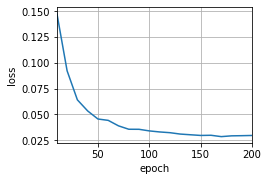

In [18]:
num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.1, 64, 10
lr, num_epochs, device = 0.005, 200, try_gpu()
ffn_num_hiddens, num_heads = 64, 4
key_size, query_size, value_size = 32, 32, 32
norm_shape = [2]

train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size, num_steps)
net = Transformer(len(src_vocab), len(tgt_vocab), key_size, query_size, value_size, num_hiddens,
                  norm_shape, ffn_num_hiddens, num_heads, num_layers, dropout)
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [19]:
def predict_seq2seq_transformer(net, src_sentence, src_vocab, tgt_vocab, num_steps, save_attention_weights = False):
    """Predict for sequence to sequence."""
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [src_vocab['<eos>']]
    enc_valid_len = tf.constant([len(src_tokens)])
    src_tokens = truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
    # Add the batch axis
    enc_X = tf.expand_dims(src_tokens, axis = 0)
    enc_outputs = net.encoder(enc_X, enc_valid_len, training = False)
    dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)
    # Add the batch axis
    dec_X = tf.expand_dims(tf.constant([tgt_vocab['<bos>']]), axis = 0)
    output_seq, attention_weight_seq = [], []
    for _ in range(num_steps):
        Y, dec_state = net.decoder(dec_X, dec_state, training = False)
        # We use the token with the highest prediction likelihood as the input
        # of the decoder at the next time step
        dec_X = tf.argmax(Y, axis = 2)
        pred = tf.squeeze(dec_X, axis = 0)
        # Save attention weights
        if save_attention_weights:
            attention_weight_seq.append(net.decoder.attention_weights)
        # Once the end-of-sequence token is predicted, the generation of the
        # output sequence is complete
        if pred == tgt_vocab['<eos>']:
            break
        output_seq.append(pred.numpy())
    return ' '.join(tgt_vocab.to_tokens(tf.reshape(output_seq, shape = -1).numpy().tolist())), attention_weight_seq

In [20]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = predict_seq2seq_transformer(net, eng, src_vocab, tgt_vocab, num_steps, True)
    print(f'{eng} => {translation}, ', f'bleu {bleu(fra, translation, k=2):.3f}')

go . => va !,  bleu 1.000
i lost . => j'ai perdu .,  bleu 1.000
he's calm . => il est calme .,  bleu 1.000
i'm home . => je suis chez moi tom a gagnã© .,  bleu 0.640


In [21]:
enc_attention_weights = tf.reshape(tf.concat(net.encoder.attention_weights, 0), shape = (num_layers, num_heads, -1, num_steps))
enc_attention_weights.shape

TensorShape([2, 4, 10, 10])

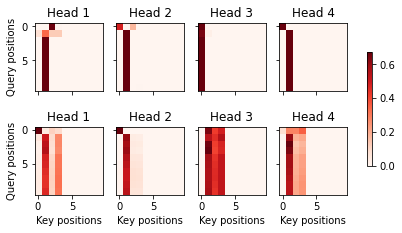

In [22]:
show_heatmaps(enc_attention_weights, xlabel='Key positions', ylabel='Query positions',
              titles=['Head %d' % i for i in range(1, 5)], figsize=(7, 3.5))

In [23]:
dec_attention_weights_2d = [head[0] for step in dec_attention_weight_seq for attn in step 
                            for blk in attn for head in blk]
dec_attention_weights_filled = tf.convert_to_tensor(
    np.asarray(pd.DataFrame(dec_attention_weights_2d).fillna(0.0).values).astype(np.float32))
dec_attention_weights = tf.reshape(dec_attention_weights_filled, shape = (-1, 2, num_layers, num_heads, num_steps))
dec_self_attention_weights, dec_inter_attention_weights = tf.transpose(dec_attention_weights, perm = (1, 2, 3, 0, 4))
print(dec_self_attention_weights.shape, dec_inter_attention_weights.shape)

(2, 4, 9, 10) (2, 4, 9, 10)


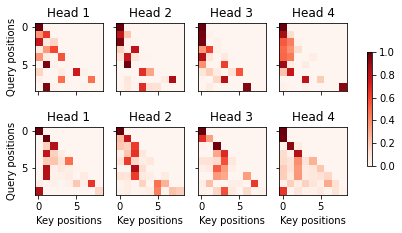

In [24]:
show_heatmaps(dec_self_attention_weights[:, :, :, :len(translation.split()) + 1], 
              xlabel='Key positions', ylabel='Query positions', 
              titles=['Head %d' % i for i in range(1, 5)], figsize=(7, 3.5))

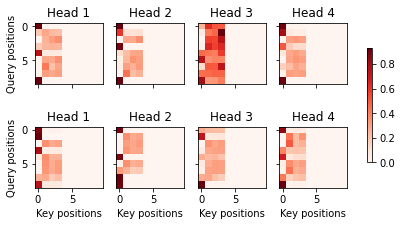

In [25]:
show_heatmaps(dec_inter_attention_weights, xlabel='Key positions', 
              ylabel='Query positions', titles=['Head %d' % i for i in range(1, 5)], figsize=(7, 3.5))